# Assignment 2: Project Group 5 

Aleksandra Siderova - s2249987

Plamen Bozov - s2319217

Lena Huster - s2239531

Danielle Ehizibue - s2028484

Judith Bravo de Medina Arribas - s2368528

Boris Belchev - s2388952



*13 October 2021*


## Introduction

DDoS attacks, also known as Denial-of-Service attacks, have been going around for over more than forty years now, increasing their power and the amount of attacks per year. These attacks are categorized as a cyberattack where the perpetrator has the intention to disrupt machines or networks in order to make them unavailable for the intended use. This disruption is typically accomplished by overloading the systems with superfluous requests from many different sources. The use of distinct sources makes it harder for the victim to block the DDoS attack. The typical targets of DDoS attacks are shopping websites or businesses who provide online services.

As mentioned before, the amount of DDoS attacks have been increasing in the last decade, as attackers find new ways to perform the attacks, as well as chasing new victims or services. Only in the past year, 2020, more than 10 million Distributed-Denial-of-Service attacks were registered, 2 million more than in 2019, which compared to the 50 thousand cases in 2015, gives the perspective that attackers are targeting more often with the development of new skills and resources during the last five years. 


## Goal & Motivation
With the increase of DDoS attacks in the last years, this research looks to analyse one of those cyberattacks, in order to understand how they work and having a real perspective on how a denial-of-service attack looks like. Furthermore, by analysing the DDos attacks collected file, the goal is set towards how to make the internet safer, by studying the aspect this attack has, what is it affecting, the time it takes, approximately, etc. This could help understanding more about necessary steps that could be taken to avoid an attack or to make it harder to perform. 

The motivation for such analysis lies in gaining more insights into how DDoS attacks work and how hackers perform them. Furthermore, the perspective of the victim will also be understood as the file to be analysed will be shown from the targeted person/company point of view. Besides, there is a chance to deepen the knowledge and understanding about how those attacks are possible and what steps are carried out by the hackers.




## Methodology & Results

### Methodology
In order to perform our research, we decided to examine a specific DDoS attack that was performed in reality by an attacker, so we could obtain relevant information analyzing a real life case of such an attack. 

We began our examination by using Wireshark to open the real_booter_attacker.pcap file, which shows all the packets that were exchanged during the attack. Despite the short period of time in which the attack took place (25.343013 seconds), the total number of packets is massive, namely 122233, which is why we decided as a next step to narrow down the packets which we want to examine in order to search for a pattern. 

To find an appropriate criteria to filter the packets by, we decided to first narrow down which packets are part of the attack. As such, we chose to leave out the ICMP packets, since they are only indirectly part of the attack as a response by the victim towards the attacker:


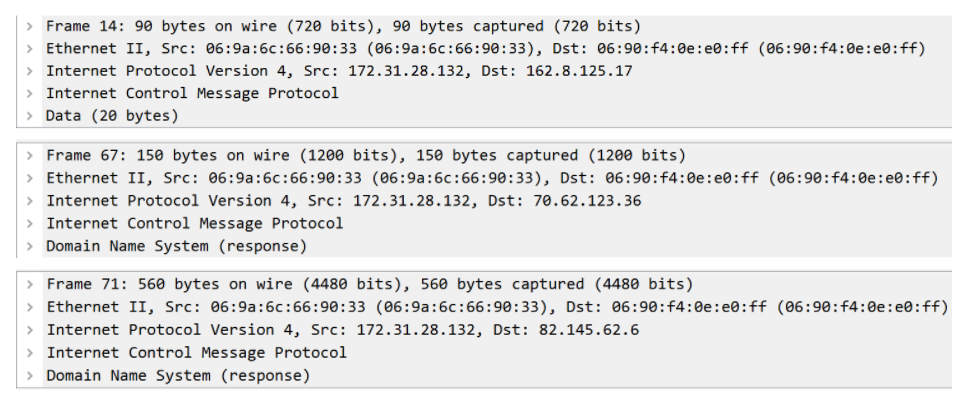

As an extension of the above reasoning, the IP addresses are an important indicator - the victim’s IP address is 172.31.28.132, while the attacker uses many different IP addresses since it’s a DDoS attack. As such, we decided to focus on packets sent to the IP address of the victim.

Furthermore, we noticed that the protocol used in the attack is DNS, so it follows that the source port on the remaining packets must be 53 - the port used for DNS. Another important pattern we discovered is that the attacker requests all the available types of information using ANY (instead of just A, AAAA, etc.), likely to get as much traffic as possible.
Putting all that information together, we used a filter in Wireshark to show only the relevant packets:


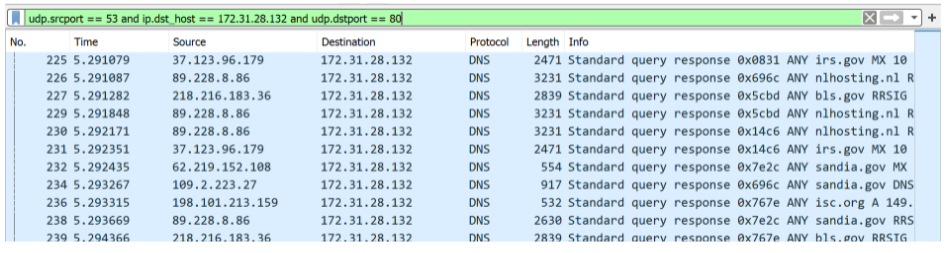

Once we narrowed down the packets, we used tools such as https://hackertarget.com/as-ip-lookup/ and https://whatismyipaddress.com/ip-lookup to gather further information about the attack, such as Autonomous Systems related to the attack, geolocations of the different IP addresses, etc., as well as statistical analyses provided by Wireshark for discovering the data rate peak and distribution of packet length. These results are discussed in the following section.

### Results

## Libraries that we used to analyse the data

In [2]:
import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.html
import seaborn as sns

plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

#Magic line: to show the plots inline in the Jupyter Notebook
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') #To avoid showing annoying warns

## Reading the pcap and Writing into a text file


In [ ]:
# This operation is extremely timing consuming. At least you only need to do it at ONCE! --> in CMD
!tshark -n -r 'real_booter_attack.pcap' -E separator=\;  -E header=y -T fields \
-e frame.time_epoch \
-e ip.proto \
-e ip.src \
-e ip.dst \
-e udp.srcport \
-e udp.dstport \
-e tcp.srcport \
-e tcp.dstport \
-e frame.len \
-e dns.qry.type \
-e dns.qry.name \
-e dns.resp.name > pcap.txt

## Reading the converted pcap file (pcap.txt) into a pandas dataframe

In [3]:
df = pd.read_csv(r'pcap.txt', error_bad_lines=False, sep='\\')

## Used Functions

In [4]:
def timestamp2datetime(series):
    return  pd.to_datetime(series,unit='s',errors='coerce')

In [5]:
def bytes2bits(series):
    try:
        return  series*8
    except AttributeError:
        return series     

## Using the above functions to convert some columns of the dataframe 

In [6]:
df['frame.time_epoch']=timestamp2datetime(df['frame.time_epoch'])

In [7]:
df['frame.len']=bytes2bits(df['frame.len'])

## Showing how the data looks like after the adaptations 

In [8]:
df.head()

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name
0,2014-12-22 15:38:42.525944710,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN
1,2014-12-22 15:38:42.525982140,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN
2,2014-12-22 15:38:42.648396015,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,1.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
3,2014-12-22 15:38:42.648422003,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,28.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
4,2014-12-22 15:38:42.648628950,17,172.31.0.2,172.31.28.132,53.0,51139.0,NaN,NaN,1312,28.0,ip-172-31-28-132.us-west-2.compute.internal,us-west-2.compute.internal


<h1 align="center">====================================================================<br> INVESTIGATING THE CHARACTERISTICS OF THE TRACE </h1>

## 1.1. Who was the target IP? Which IP was the target of the majority of packets?

In [9]:
ip_dst=df['ip.dst'].value_counts()
# Showing only the top ones
ip_dst.head()

172.31.28.132                 120253
172.31.0.2                       100
61.93.9.158,172.31.28.132         26
92.103.90.30,172.31.28.132        26
82.145.62.5,172.31.28.132         26
Name: ip.dst, dtype: int64

#### Answer: As we can see, the IP adress 172.31.28.132 is repeated the most, therefore, the IP 172.31.28.132 was the target of the attack.

## 1.2. Visualizing the distribution of destination IPs and the percentage of packets 

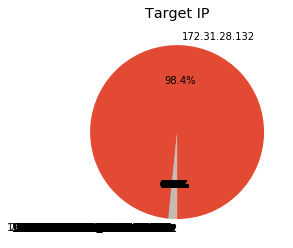

In [10]:
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_dst.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="Target IP")
ax.set_ylabel("")

fig.show()

## 1.3. The IP that most received packets was 172.31.28.132

In [11]:
top1_target_ip=ip_dst.index[0]
top1_target_ip

'172.31.28.132'

## 2.1. Which \16 network the target IP belongs?

In [12]:
target_network=top1_target_ip.split('.')[0]+'.'+top1_target_ip.split('.')[1]
target_network

'172.31'

**Answer: the target belongs to the \16 network of 172.31**

## 3.1. Which IP protocols occurred more in the trace?

In [13]:
ip_proto=df['ip.proto'].value_counts()
ip_proto.head()

17      120350
1,17      1878
1            4
6            1
Name: ip.proto, dtype: int64

#### Answer: The protocol number 17 occured most in the trace. Protocol 17 is the User Datagram Protocol (UDP)

## 3.2. Visualizing the distribution of IP protocols

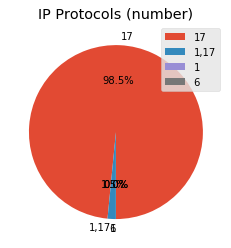

In [14]:
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_proto.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="IP Protocols (number)")
ax.set_ylabel("")
plt.legend()

fig.show()

## 3.3. The IP protocol that occurred more was 17 

In [15]:
top1_target_ip_proto=ip_proto.index[0]
top1_target_ip_proto

'17'

## 4.1. How is the Distribution of UDP ports for the top 1 (or 2) target IP address(es)?

In [16]:
udp_srcip_dstip_top1=df[df['ip.dst']==top1_target_ip]['ip.src'].value_counts()
udp_srcport_top1=df[df['ip.dst']==top1_target_ip]['udp.srcport'].value_counts()
udp_dstport_top1=df[df['ip.dst']==top1_target_ip]['udp.dstport'].value_counts()

top2_target_ip= ip_dst.index[1]
top2_target_ip

udp_srcip_dstip_top2=df[df['ip.dst']==top2_target_ip]['ip.src'].value_counts()
udp_srcport_top2=df[df['ip.dst']==top2_target_ip]['udp.srcport'].value_counts()
udp_dstport_top2=df[df['ip.dst']==top2_target_ip]['udp.dstport'].value_counts()

print(udp_srcport_top1)
print(udp_dstport_top1)

53.0      120249
1988.0         1
Name: udp.srcport, dtype: int64
80.0       120149
33810.0         2
60233.0         2
51985.0         2
51893.0         2
60000.0         2
43500.0         2
59694.0         2
59692.0         2
34828.0         2
51139.0         2
58660.0         2
33793.0         2
48940.0         2
41916.0         2
58224.0         2
33616.0         2
33609.0         2
58128.0         2
49862.0         2
41637.0         2
57931.0         2
33181.0         2
40964.0         2
35783.0         2
49086.0         2
44101.0         2
44496.0         2
48705.0         2
56849.0         2
56813.0         2
48103.0         2
47909.0         2
39588.0         2
47697.0         2
38935.0         2
47118.0         2
46936.0         2
55109.0         2
38604.0         2
46481.0         2
46368.0         2
46314.0         2
54482.0         2
38030.0         2
37967.0         2
54245.0         2
37716.0         2
36642.0         2
44794.0         2
60481.0         2
33434.0         

## 4.2. Visualizing the distribution of src IPs and the (src and dst) UDP ports

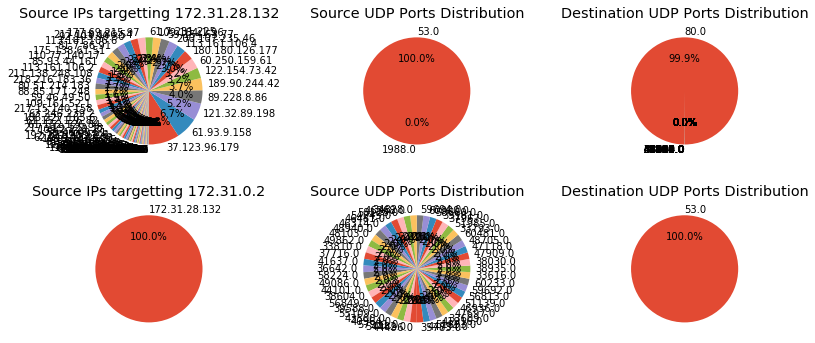

In [17]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(wspace=1)

ax = plt.subplot2grid((2,3), (0,0))
udp_srcip_dstip_top1.plot(kind='pie',ax=ax, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top1_target_ip)
ax.set_ylabel("")

ax1 = plt.subplot2grid((2,3), (0,1))
udp_srcport_top1.plot(kind='pie',ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
ax1.set_ylabel("")

ax2 = plt.subplot2grid((2,3), (0,2))
udp_dstport_top1.plot(kind='pie',ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
ax2.set_ylabel("")

ax3 = plt.subplot2grid((2,3), (1,0))
udp_srcip_dstip_top2.plot(kind='pie',ax=ax3, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top2_target_ip)
ax3.set_ylabel("")

ax4 = plt.subplot2grid((2,3), (1,1))
udp_srcport_top2.plot(kind='pie',ax=ax4, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
ax4.set_ylabel("")

ax5 = plt.subplot2grid((2,3), (1,2))
udp_dstport_top2.plot(kind='pie',ax=ax5, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
ax5.set_ylabel("")

fig.show()

**Answer: From the above figures we see that the top src port was 53 (DNS)**

## 5.1. What were the DNS queries used in the attack?

In [18]:
occurrence_dnsquery=df['dns.qry.name'].value_counts()
occurrence_dnsquery.head()

bls.gov         24374
nlhosting.nl    17918
sandia.gov      15805
isc.org         12504
verisign.com    10500
Name: dns.qry.name, dtype: int64

## 5.2. Visualizing the distribution of DNS queries

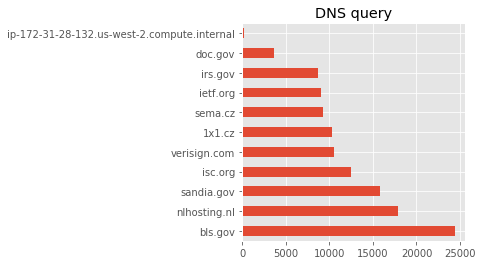

In [19]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot2grid((1,1), (0,0))
occurrence_dnsquery.plot(kind='barh',ax=ax, fontsize=10, title="DNS query")
ax.set_ylabel("")

fig.show()

## 5.3. Well, considering that only the top 1 DNS query was used in the attack... 

In [20]:
top_dnsquery=occurrence_dnsquery.index[0]
top_dnsquery

'bls.gov'

## 6.1. What was the greatest frame length that the DNS query used on the attack had? (i.e., which generated the greatest amplification factor)

In [21]:
max(df['frame.len'][df['dns.qry.name']==top_dnsquery])

31656

## 7.1.: Defining ONLY the main attack records<br>

In [22]:
# MANUAL SELECTION: Considering the attack from ONE to ONE port!!!
attack_records=df[df['ip.dst']==top1_target_ip]\
                [df['ip.src'].str.contains(target_network)==False]\
                [df['ip.proto']==top1_target_ip_proto]\
                [df['udp.srcport']==udp_srcport_top1.index[0]]\
                [df['udp.dstport']==udp_dstport_top1.index[0]]

# # MANUAL SELECTION: Considering the attack from ONE to MANY ports!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]
                
# # MANUAL SELECTION: Considering the attack from MANY to ONE port!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]

# # MANUAL SELECTION: Considering the attack from MANY to MANY portS!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]

remaining_records=df[~df.isin(attack_records)]


## 8.1. Generating a time series of the attack and the remaining traffic

In [23]:
overall_bps=df.set_index(['frame.time_epoch']).groupby(pd.Grouper(freq='S')).agg(['sum'])['frame.len']
attack_bps=attack_records.set_index(['frame.time_epoch']).groupby(pd.Grouper(freq='S')).agg(['sum'])['frame.len']
attack_bps_median=attack_bps.median()
attack_bps_peak=max(attack_bps['sum'])

remaining_bps=remaining_records.set_index(['frame.time_epoch']).groupby(pd.Grouper(freq='S')).agg(['sum'])['frame.len']

## 8.2. Visualizing the time series 

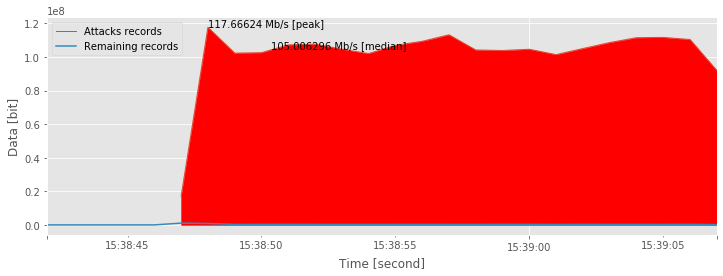

In [24]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot2grid((1,1), (0,0))

attack_bps.plot(ax=ax, lw=1)
ax.fill_between(attack_bps.index, 0, attack_bps['sum'],color='r')

ax.annotate(str(attack_bps_peak/10e5)+' Mb/s [peak]', (str(attack_bps[attack_bps['sum'] == attack_bps_peak].index.values[0]), attack_bps_peak),
             xytext=(0, 0), textcoords='offset points')
ax.annotate(str(attack_bps_median[0]/10e5)+' Mb/s [median]', (str(attack_bps.index.values[0]), attack_bps_median),
             xytext=(90, 0), textcoords='offset points')

remaining_bps.plot(ax=ax)

ax.legend(['Attacks records','Remaining records'])
ax.set_ylabel("Data [bit]")
ax.set_xlabel("Time [second]")

fig.show()

**As we can see in the above figure, the data rate peak of the attack is 117.66624 Mbit/s.**

## The distribution/frequency of TCP flags involved in the attack

**Answer: There is no distribution of TCP flags. It is UDP based attack because DNS service is accessible through the UDP port.
In the image below we can see the distribution of packet lengths for the applied filter.**

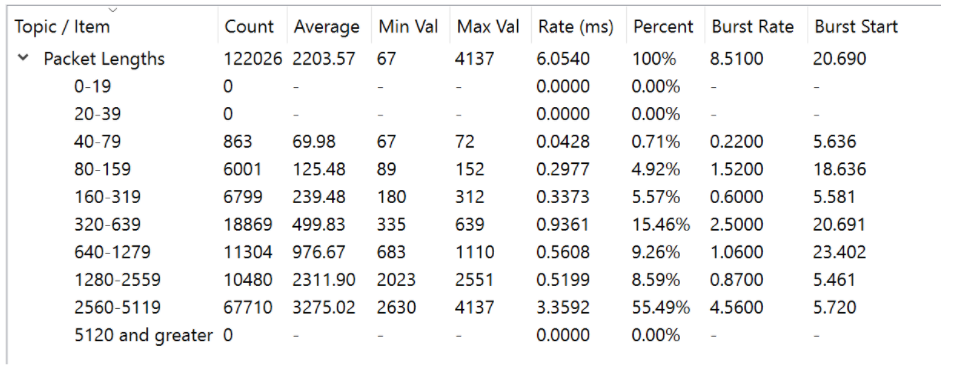

## 9.1. How many records in the entire trace, attack records, and remaining records? 

In [25]:
print('Records:', len(df),'records (100%),',len(attack_records),'attack records (',len(attack_records)*100/len(df),'%)',',', len(df)-len(attack_records),'remaining records (',(len(df)-len(attack_records))*100/len(df),'% )')

Records: 122233 records (100%), 120149 attack records ( 98.29505943566795 %) , 2084 remaining records ( 1.7049405643320543 % )


## 10.1. What is the duration of the entire trace and the attack part? 

In [26]:
print('Trace duration:',max(df['frame.time_epoch'])-min(df['frame.time_epoch']))
print('Attack duration:',max(attack_records['frame.time_epoch'])-min(attack_records['frame.time_epoch']))

Trace duration: 0 days 00:00:25.343013
Attack duration: 0 days 00:00:20.156359


## 11.1. How many (source) IPs were involved in the attack?

In [27]:
len(attack_records['ip.src'].unique())

79

**Answer: So, as we can see, 79 different sources performed the attack.**

## 12.1. What are the top 5 IP addresses that sent more packets?

In [28]:
top5_srcips_pkts=attack_records['ip.src'].value_counts().head(5).sort_values()
top5_srcips_pkts

189.90.244.42     4433
89.228.8.86       4831
121.32.89.198     6261
61.93.9.158       8086
37.123.96.179    11126
Name: ip.src, dtype: int64

**Answer: The top 3 IP addresses are: 37.123.96.179, 61.93.9.158, 121.32.89.198**

## 12.2. Visualizing the top 5 IP addresses that sent more packets

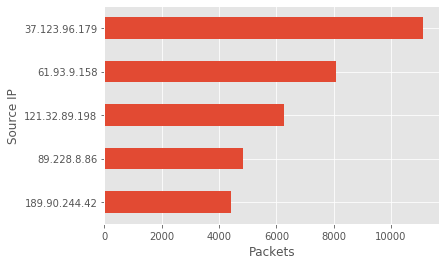

In [29]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_pkts.plot(kind='barh')
ax.set_ylabel("Source IP")
ax.set_xlabel("Packets")

fig.show()

## 13.1. What are the top 5 IP addresses that sent more attack data?

In [30]:
top5_srcips_bits=attack_records.groupby('ip.src').agg(['sum'])['frame.len'].sort_values('sum',ascending=False).head(5).sort_values('sum', ascending=False)
top5_srcips_bits

,sum
ip.src,
37.123.96.179,290276352
61.93.9.158,196340544
121.32.89.198,114598400
189.90.244.42,106533112
60.250.159.61,89142944


## 13.2. Visualizing the top 5 IP addresses that sent more attack data

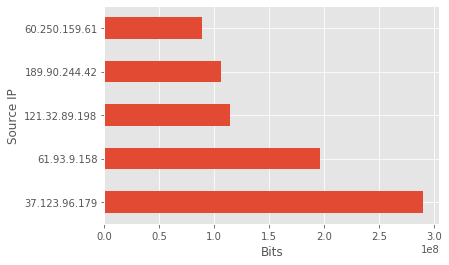

In [31]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_bits.plot(kind='barh',ax=ax,legend=False)
ax.set_ylabel("Source IP")
ax.set_xlabel("Bits")

fig.show()

## 13.3. Well, the top 1 Source IP was ...

In [32]:
top1_srcips_bits = top5_srcips_bits.index[0]
top1_srcips_bits 

'37.123.96.179'

## 14.1. In which country the top 1 source IP address is located?

In [34]:
import socket
from cymruwhois import Client
ip = top1_srcips_bits
c=Client()
r=c.lookup(ip)
print(r.owner)

SPD-NET, TR


#### Answer: The top 1 source IP address is located in Turkey (TR)
**Thus, for the top 3 mentioned before, the locations are:**

**1. Manisa, Turkey (37.123.96.179)**

**2. Guangzhou, China (121.32.89.198)**

**3. Tai Wan, Hong Kong (61.93.9.158)**


## The Autonomous Systems that are related to the top 3 source IP addresses

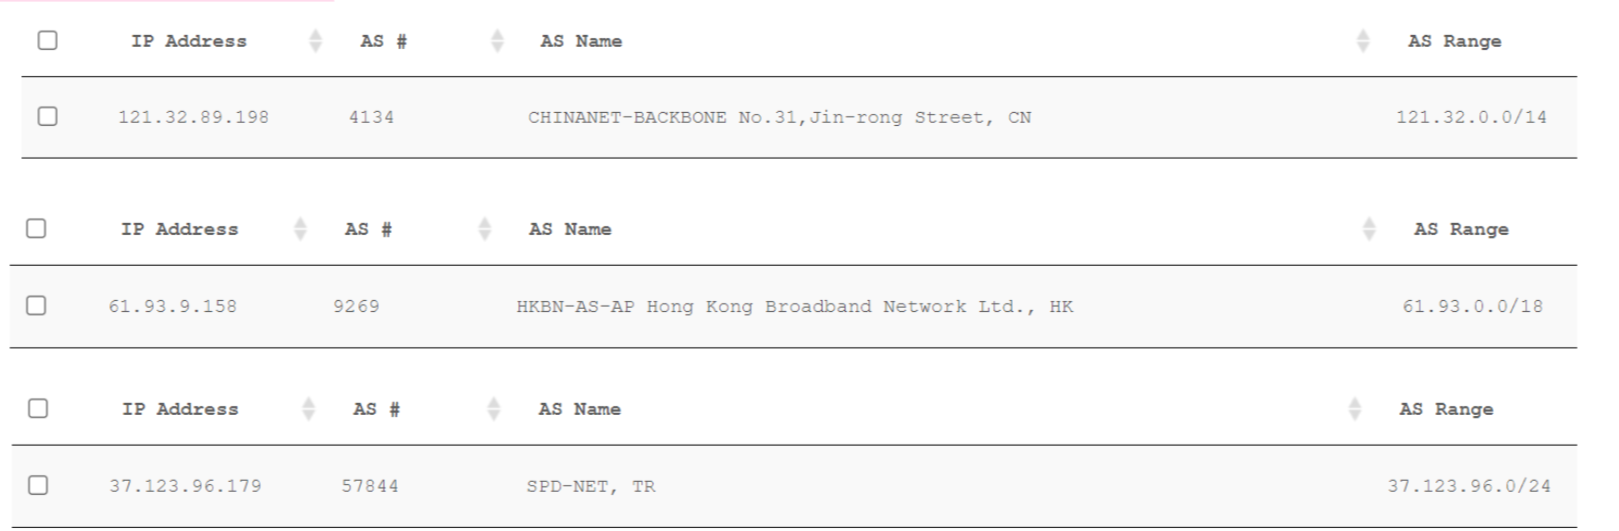

## The distribution of vendors related to the source IP addresses involved in the attack

**Answer: We used the MAC Address to Vendor, although, no vendor was found.**

**61.93.9.158 MAC address is 06:90:f4:0e:e0:ff**

**37.123.96.179 MAC address is 06:90:f4:0e:e0:ff**

**121.32.89.198 MAC address is 06:90:f4:0e:e0:ff**


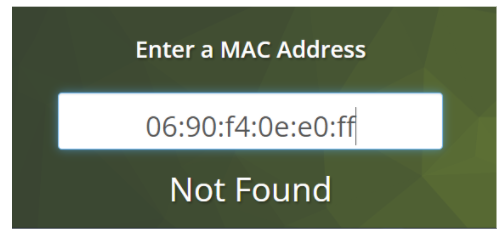

## Conclusion and Reflection

While investigating the DDoS attack saw how dangerous it can be for a system and how much resources it actually needs in order to be done. The attack we investigated is just one example of what is done every day to a lot of systems. In this attack we saw that it is not only a simple DDoS attack but is also combined with reflection attack so the attacker is more difficult to be found out. In that way the attacker imitates to be the victim and requests even more packets, which increases the overload rate for the actual victim and also makes it harder to see what is the exact aim of the attack. 


In order to be discrete the attacker uses multiple computers from different countries, mostly in Asia - Turkey, Taiwan and China. This makes it not even hard to catch, but also starts cases in different countries, which becomes legally hard to prove and also makes it expensive to target and sue the attacker. 
The speed of the attack was 120 Mbps, which for the internet nowadays is not that high speed, however it is enough to crash a well working system. 


As there are 122233 records sent for only 25 seconds, this makes 4889 packets per second which is a lot. Compared to the ones that send 1.5 terabits per second it is still light, so it really depends on the exact system what harm it has caused.
Not all packets from the capture were actually part of the attack. We found that 80% of the traffic was part of the DDoS, but there were still normal requests, which is normal. However this makes it even worse, as the normal packets are being dropped and in that case only help to overload the victim’s system. 
To conclude this DDoS attack showed us an example of how it is done properly. Even though the example we saw might not overload a strong system it is still harmful and can cause a lot of damage. Nevertheless those types of attacks are becoming more common and are still going to be part of the internet. In order to have proper protection against them the only secure way is to disconnect. However, in the 21 century this is impossible if it is not a home or local system.


## References

DDoS Attacks History. (2017, March 12). Radware. https://www.radware.com/security/ddos-knowledge-center/ddos-chronicles/ddos-attacks-history/


FadilpaŠIć, S. (2021, January 27). A record number of DDoS attacks took place in 2020. ITProPortal. https://www.itproportal.com/news/a-record-number-of-ddos-attacks-took-place-in-2020/


DDoS Attacks: 2015 Results. (2018, June 29). PRnewswire. https://www.prnewswire.com/news-releases/ddos-attacks-2015-results-300215975.html
